In [4]:
# Cell 1 — Setup: paths & imports (edit paths here)
PRED_CSV_PATH = r"C:\Users\sinha\notebook\test_predictions.csv"        # <-- predictions CSV (id, prediction)
ACTUAL_CSV_PATH = r"C:\Users\sinha\Downloads\Actual_Annotation - Final_Majority_Annotation.csv"    # <-- actual labels CSV (Id, Actual_label)
TEST_AUDIO_DIR = r"C:\Users\sinha\Downloads\tsda_test_dataset-20251030T122450Z-1-001\tsda_test_dataset\test_set"                 # <-- folder with test wav files (ids are filenames without ext)
# Optional (for re-eval & embedding analysis)
MODEL_PATH = r"C:\Users\sinha\notebook\best_model_fold_1.pth"          # <-- your saved model checkpoint (optional)
TRAIN_AUDIO_DIR = r"C:\Users\sinha\Downloads\tsda_dataset-20251015T052020Z-1-001\tsda_dataset\audio"               # <-- training audio folder (optional, for class centroids)
TRAIN_META_CSV = r"C:\Users\sinha\Downloads\tsda_dataset-20251015T052020Z-1-001\tsda_dataset\meta\sound_50.csv"               # <-- training metadata (optional)

# Basic imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Audio, display
import librosa, librosa.display
import torchaudio

# Machine learning metrics + visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import itertools

sns.set(style="whitegrid")
%matplotlib inline


In [5]:
# Cell 2 — Utility: load predictions & actuals (robust to column names)
def load_predictions_and_actuals(pred_csv, actual_csv):
    preds = pd.read_csv(pred_csv)
    actuals = pd.read_csv(actual_csv, sep=None, engine='python')  # handle various separators
    
    # Normalise column names
    preds_columns = [c.lower() for c in preds.columns]
    if "id" in preds_columns:
        preds = preds.rename(columns={preds.columns[preds_columns.index("id")]: "id"})
    if "prediction" not in preds.columns and "pred" in preds_columns:
        preds = preds.rename(columns={preds.columns[preds_columns.index("pred")]: "prediction"})
    
    actuals_columns = [c.lower() for c in actuals.columns]
    # Accept 'id' or 'Id' or 'ID' and 'actual_label' or 'label' or 'target'
    if "id" in actuals_columns:
        actuals = actuals.rename(columns={actuals.columns[actuals_columns.index("id")]: "id"})
    elif "Id" in actuals.columns:
        actuals = actuals.rename(columns={actuals.columns[actuals_columns.index("Id")]: "id"})
    # actual label column
    for candidate in ["actual_label", "actual", "label", "target", "Actual_label", "Actual"]:
        if candidate in actuals.columns:
            actuals = actuals.rename(columns={candidate: "actual"})
            break
    # fallback if second column is label
    if "actual" not in actuals.columns:
        actuals = actuals.rename(columns={actuals.columns[1]: "actual"})
    
    # make id strings consistent (remove file extension possibly)
    preds['id'] = preds['id'].astype(str).str.strip().apply(lambda s: os.path.splitext(s)[0])
    actuals['id'] = actuals['id'].astype(str).str.strip().apply(lambda s: os.path.splitext(s)[0])
    preds['prediction'] = preds['prediction'].astype(int)
    actuals['actual'] = actuals['actual'].astype(int)
    
    merged = pd.merge(actuals, preds, on="id", how="left")  # missing preds will be NaN
    return merged, preds, actuals

merged, preds_df, actuals_df = load_predictions_and_actuals(PRED_CSV_PATH, ACTUAL_CSV_PATH)
print(f"Total test samples (actual): {len(actuals_df)}")
print(f"Total predictions: {len(preds_df)}")
print(f"Merged rows: {len(merged)}")
merged.head()


Total test samples (actual): 764
Total predictions: 764
Merged rows: 764


,id,actual,prediction
0,7-280602-A-001,37,37
1,7-280602-A-002,37,37
2,7-280602-A-003,37,37
3,7-280602-A-004,37,37
4,7-280602-A-005,37,37


In [6]:
# Cell 3 — Quick stats & basic checks
total = len(merged)
missing_preds = merged['prediction'].isna().sum()
print(f"Missing predictions (rows with no predicted label): {missing_preds}/{total}")
if missing_preds>0:
    display(merged[merged['prediction'].isna()].head())

# Quick accuracy
y_true = merged['actual'].values
y_pred = merged['prediction'].fillna(-1).astype(int).values  # -1 => missing
valid_idx = merged['prediction'].notna()
acc = accuracy_score(y_true[valid_idx], y_pred[valid_idx])
print(f"Test accuracy (from CSV): {acc*100:.2f}%")
print("\nTop-level distribution of predicted classes vs actual classes:")
display(pd.DataFrame({
    'actual_count': merged['actual'].value_counts().sort_index(),
    'pred_count': merged['prediction'].value_counts().sort_index()
}).fillna(0).astype(int).head(15))


Missing predictions (rows with no predicted label): 0/764
Test accuracy (from CSV): 59.82%

Top-level distribution of predicted classes vs actual classes:


,actual_count,pred_count
0,20,20
1,5,4
2,5,5
3,20,21
4,16,9
5,16,7
6,5,5
7,36,13
8,5,5
9,20,20


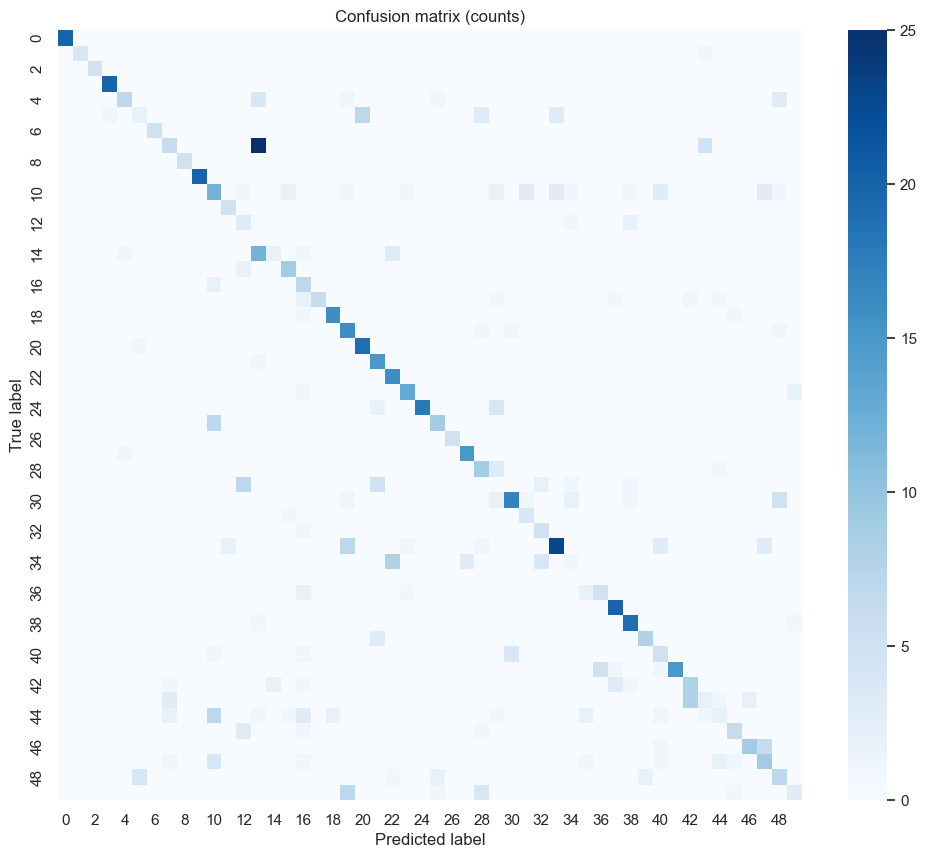

C:\Users\sinha\AppData\Local\Temp\ipykernel_16732\865111957.py:15: RuntimeWarning: invalid value encountered in divide
  cm_norm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


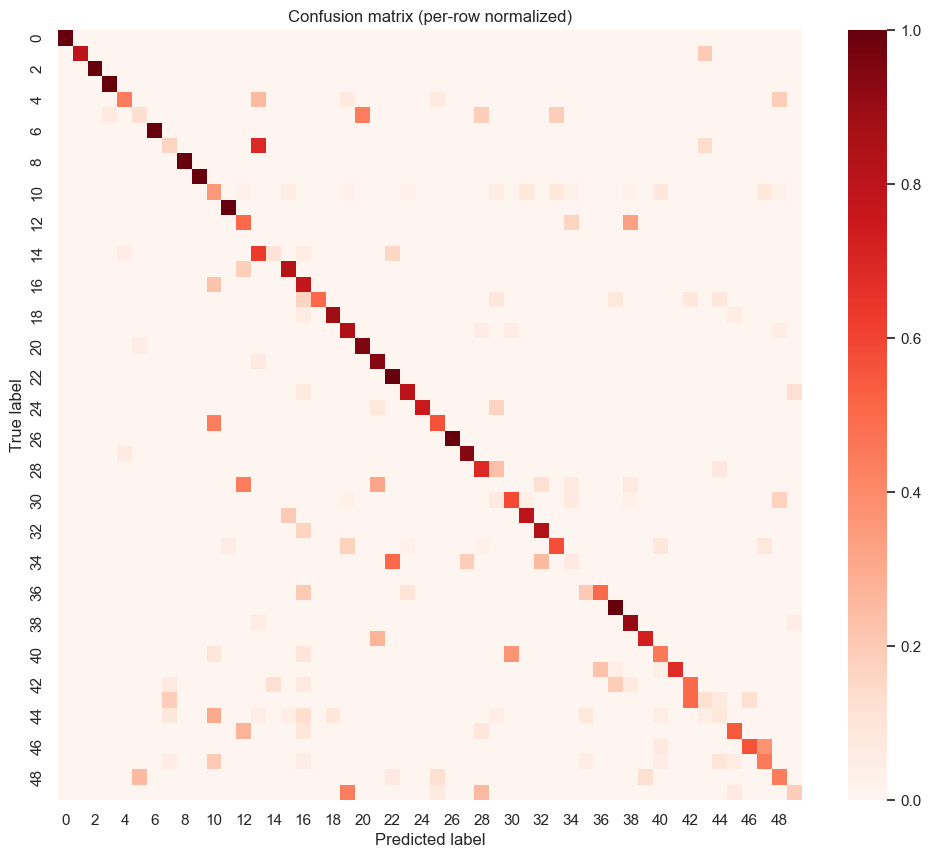

Classification report (per-class precision/recall/F1):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.95      1.00      0.98        20
           4       0.78      0.44      0.56        16
           5       0.29      0.12      0.17        16
           6       1.00      1.00      1.00         5
           7       0.46      0.17      0.24        36
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00        20
          10       0.36      0.35      0.36        34
          11       0.71      1.00      0.83         5
          12       0.19      0.50      0.27         6
          13       0.00      0.00      0.00         0
          14       0.50      0.11      0.17        19
          15       0.69      0.82      0.75        11
          16       0.32  

In [7]:
# Cell 4 — Confusion matrix (50 classes), classification report
from sklearn.utils.multiclass import unique_labels
labels = np.arange(0,50)   # ESC-50 classes 0..49 (adjust if different)
cm = confusion_matrix(y_true[valid_idx], y_pred[valid_idx], labels=labels)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (counts)")
plt.show()

# Normalized confusion matrix (by true-class rows)
cm_norm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
# handle division by zero
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, cmap='Reds', vmin=0, vmax=1)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (per-row normalized)")
plt.show()

# Classification report
from sklearn.metrics import classification_report
report = classification_report(y_true[valid_idx], y_pred[valid_idx], labels=labels, zero_division=0)
print("Classification report (per-class precision/recall/F1):\n")
print(report)


Top 10 most common confusions (true -> pred) with counts:
  7 -> 13 : 25 times
  14 -> 13 : 12 times
  34 -> 22 : 8 times
  43 -> 42 : 8 times
  5 -> 20 : 7 times
  25 -> 10 : 7 times
  29 -> 12 : 7 times
  33 -> 19 : 7 times
  44 -> 10 : 7 times
  49 -> 19 : 7 times


,class,support,correct,accuracy
13,13,0,0,0.000000
29,29,16,0,0.000000
35,35,0,0,0.000000
34,34,16,1,0.062500
44,44,23,2,0.086957
14,14,19,2,0.105263
43,43,16,2,0.125000
5,5,16,2,0.125000
7,7,36,6,0.166667
49,49,16,3,0.187500


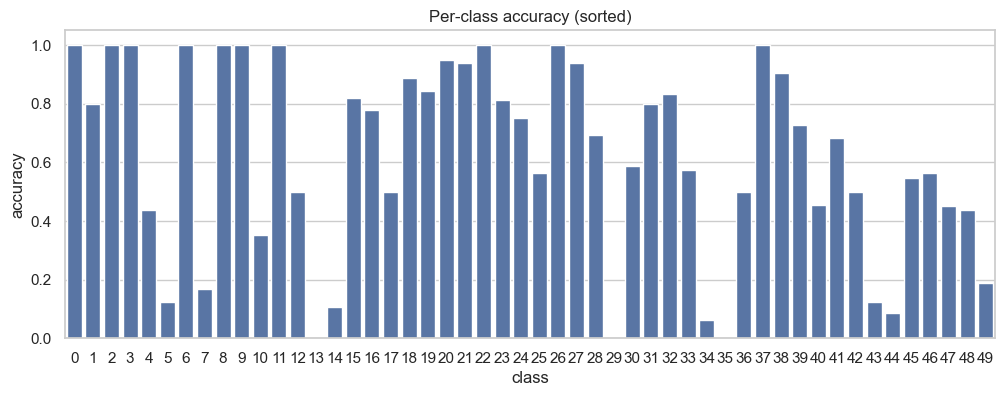

In [8]:
# Cell 5 — Top confused pairs & per-class error rates
# Identify most confused pairs (true -> predicted) excluding diagonal
conf_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i==j: continue
        conf_pairs.append(((i,j), cm[i,j]))
conf_pairs = sorted(conf_pairs, key=lambda x: x[1], reverse=True)

print("Top 10 most common confusions (true -> pred) with counts:")
for (t,p),cnt in conf_pairs[:10]:
    print(f"  {t} -> {p} : {cnt} times")

# Per-class accuracy (row-wise diagonal)
per_class_acc = np.diag(cm) / (cm.sum(axis=1) + 1e-12)
per_class_df = pd.DataFrame({
    'class': labels,
    'support': cm.sum(axis=1),
    'correct': np.diag(cm),
    'accuracy': per_class_acc
}).sort_values('accuracy')
display(per_class_df.head(10))     # worst performing classes
plt.figure(figsize=(12,4))
sns.barplot(x='class', y='accuracy', data=per_class_df.sort_values('accuracy'))
plt.title('Per-class accuracy (sorted)')
plt.show()


In [9]:
# Cell 6 — Inspect misclassified examples for a chosen confusion pair
# Replace true_class and pred_class with values from the top confusions printed above.
true_class = int(per_class_df.sort_values('accuracy').iloc[0]['class'])  # example: worst class
pred_class = conf_pairs[0][0][1]  # most confused predicted class
print("Inspecting examples where", true_class, "was predicted as", pred_class)

def show_examples_of_pair(df_merged, true_c, pred_c, audio_dir, n=6):
    sub = df_merged[(df_merged['actual']==true_c) & (df_merged['prediction']==pred_c)]
    print(f"Found {len(sub)} examples for {true_c} -> {pred_c}. Showing up to {n}.")
    for idx, row in sub.head(n).iterrows():
        fid = row['id']
        path_wav = Path(audio_dir) / (str(fid) + ".wav")
        if not path_wav.exists():
            # try wav uppercase or other ext
            try_glob = list(Path(audio_dir).glob(f"{fid}.*"))
            if try_glob:
                path_wav = try_glob[0]
            else:
                print("Missing audio for id:", fid)
                continue
        print("\nID:", fid, "| true:", true_c, "| pred:", pred_c, "| file:", path_wav.name)
        # show waveform + spectrogram and play audio
        y, sr = librosa.load(path_wav, sr=None)
        display(Audio(y, rate=sr))
        plt.figure(figsize=(10,2))
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Waveform: {fid} (sr={sr})")
        plt.show()
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10,3))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Mel spectrogram")
        plt.show()

# Run the example viewer
show_examples_of_pair(merged, true_class, pred_class, TEST_AUDIO_DIR, n=4)


Inspecting examples where 13 was predicted as 13
Found 0 examples for 13 -> 13. Showing up to 4.


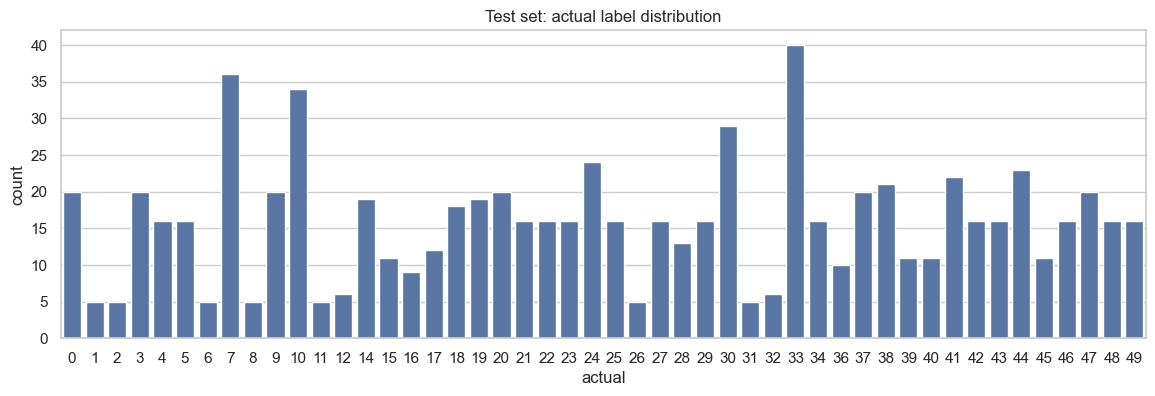

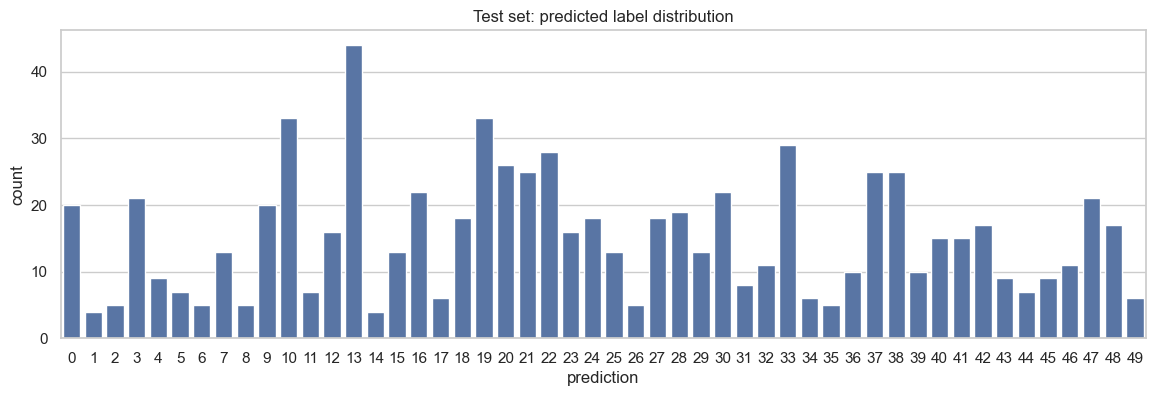

In [10]:
# Cell 7 — Check label-distribution shifts / class imbalance in test set
plt.figure(figsize=(14,4))
ax = sns.countplot(x='actual', data=merged, order=sorted(merged['actual'].unique()))
plt.title("Test set: actual label distribution")
plt.show()

plt.figure(figsize=(14,4))
ax = sns.countplot(x='prediction', data=merged[merged['prediction'].notna()], order=sorted(merged['prediction'].dropna().unique()))
plt.title("Test set: predicted label distribution")
plt.show()


In [17]:
# ---------------------------
# OPTIONAL: Re-evaluate using saved model (produce probs & embeddings)
# ---------------------------
# This section runs inference using your saved model to get full logits/probs and features.
# Useful for Top-K metrics and t-SNE/UMAP visualizations.

# Requirements: your notebook environment MUST have the same model architecture (get_model) and CFG
# If `get_model` and CFG are available in your notebook, they'll be used. Otherwise we create a fallback.
import random
import torchaudio.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

import timm
from torch_audiomentations import Compose, Gain, AddColoredNoise, PitchShift, Shift
class CFG:
    # General
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- IMPORTANT: Update this path to your dataset location ---
    DATA_PATH = r"C:\Users\sinha\Downloads\tsda_dataset-20251015T052020Z-1-001\tsda_dataset"
    AUDIO_PATH = os.path.join(DATA_PATH, "audio")
    META_PATH = os.path.join(DATA_PATH, "meta/sound_50.csv")
    
    # Audio Parameters
    SAMPLING_RATE = 44100
    N_FFT = 2048        
    WIN_LENGTH = 1024     
    HOP_LENGTH = 512
    N_MELS = 128 # We will use 128 mels, and resize
    
    # Model & Training
    MODEL_NAME = 'efficientnet_b2' # Using a slightly larger B2
    TARGET_SIZE = 260 # Default input size for EfficientNet-B2
    NUM_CLASSES = 50
    BATCH_SIZE = 32 # B2 is larger, lower batch size if you get OOM errors
    EPOCHS = 50          
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-2    
    
    # --- NEW: Mixup Configuration ---
    MIXUP_ALPHA = 0.4 # How much to mix. 0.0 = no mixup

    # Optional: compute "clean" (non-mixup) train accuracy (slower)
    CLEAN_TRAIN_ACC = False

def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.SEED)
print(f"Using device: {CFG.DEVICE}")
print(f"Using model: {CFG.MODEL_NAME}")

# --- Spectrogram Transforms ---

# Base Mel Spectrogram pipeline
mel_transform = T.MelSpectrogram(
    sample_rate=CFG.SAMPLING_RATE,
    n_fft=CFG.N_FFT,
    win_length=CFG.WIN_LENGTH,
    hop_length=CFG.HOP_LENGTH,
    n_mels=CFG.N_MELS
)
db_transform = T.AmplitudeToDB()

# This is the base transform
spec_transform = nn.Sequential(
    mel_transform,
    db_transform
).to(CFG.DEVICE)

# --- NEW: Delta Transform ---
# This computes the delta (velocity) of the spectrogram
delta_transform = T.ComputeDeltas().to(CFG.DEVICE)

# --- NEW: SpecAugment (we'll still use this) ---
spec_augmenter = nn.Sequential(
    T.FrequencyMasking(freq_mask_param=24), # Mask ~20% of mel bins (24/128)
    T.TimeMasking(time_mask_param=50)      # Mask ~10-12% of time steps
).to(CFG.DEVICE)


# --- Check Dataset Paths ---
try:
    audio_files = os.listdir(CFG.AUDIO_PATH)
    print(f"Found {len(audio_files)} audio files in {CFG.AUDIO_PATH}")
    meta_files = os.listdir(os.path.join(CFG.DATA_PATH, "meta"))
    print(f"Found metadata files: {meta_files}")
except FileNotFoundError:
    print(f"Error: Dataset not found. Please check the DATA_PATH in the CFG class.")
    print(f"Current DATA_PATH: {CFG.DATA_PATH}")

df = pd.read_csv(CFG.META_PATH)
print("Metadata DataFrame Head:")
print(df.head())


def get_model(num_classes=CFG.NUM_CLASSES, pretrained=True):
    """
    Loads a pre-trained EfficientNet-B2 model.
    We will use the default in_chans=3, as we will be feeding it
    a 3-channel spectrogram (Mel, Delta, Delta-Delta).
    """
    model = timm.create_model(
        CFG.MODEL_NAME,
        pretrained=pretrained,
        num_classes=num_classes,
        # in_chans=3 is the default, so no change needed
    )
    return model

model_check = get_model(num_classes=CFG.NUM_CLASSES)
print(f"\nUsing Pre-trained {CFG.MODEL_NAME} Model Architecture.")
# print(model_check.default_cfg) # Uncomment to check default config


# --- UPDATED: Dataset Class ---
class ESC50Dataset(Dataset):
    def __init__(self, df, data_path, fold_to_exclude, is_train=True, 
                 transform=None, 
                 delta_transform=None,
                 waveform_augmentations=None,
                 spec_augmenter=None):
        
        self.data_path = data_path
        if is_train:
            self.df = df[df['fold'] != fold_to_exclude].reset_index(drop=True)
        else:
            self.df = df[df['fold'] == fold_to_exclude].reset_index(drop=True)
            
        # Move nn transforms to CPU for dataloading (they will be sent to device later)
        # Note: these transforms are simple torch modules; keeping them on CPU avoids some issues with DataLoader workers
        self.transform = transform.to("cpu") if transform is not None else None
        self.delta_transform = delta_transform.to("cpu") if delta_transform is not None else None
        self.waveform_augmentations = waveform_augmentations
        self.spec_augmenter = spec_augmenter.to("cpu") if spec_augmenter else None
        self.is_train = is_train
        self.target_length = 5 * CFG.SAMPLING_RATE # 5 seconds
        self.target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.data_path, row['filename'])
        
        waveform, sr = torchaudio.load(file_path)  # waveform: [channels, time]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        
        if sr != CFG.SAMPLING_RATE:
            waveform = T.Resample(sr, CFG.SAMPLING_RATE)(waveform)
        
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        waveform = waveform.to(dtype=torch.float32)
        
        # 1. Waveform Augmentations
        if self.is_train and self.waveform_augmentations is not None:
            added_batch = False
            # torch_audiomentations expects [batch, channels, time] OR [channels, time] depending on API
            if waveform.dim() == 2:
                # make batch dim
                waveform = waveform.unsqueeze(0)  # [1, 1, time]
                added_batch = True
   
            try:
                augmented = self.waveform_augmentations(samples=waveform, sample_rate=CFG.SAMPLING_RATE)
            except TypeError:
                augmented = self.waveform_augmentations(waveform, CFG.SAMPLING_RATE)

            if isinstance(augmented, dict):
                augmented = augmented.get('samples', augmented.get('augmented_samples'))
            
            if added_batch:
                augmented = augmented.squeeze(0)
            
            waveform = augmented.to(dtype=torch.float32)

        # 2. Pad or Truncate
        n_samples = waveform.shape[1]
        if n_samples < self.target_length:
            pad_amount = self.target_length - n_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        else:
            waveform = waveform[:, : self.target_length]
        
        
        # 3. Create Spectrogram (Channel 1: Log-Mel)
        # self.transform expects [batch, time] or [time], but gets [1, time]
        # Let's squeeze it
        spectrogram = self.transform(waveform.squeeze(0)) # -> [n_mels, n_frames]
        
        # 4. Apply SpecAugment (only for training)
        if self.is_train and self.spec_augmenter is not None:
            spectrogram = self.spec_augmenter(spectrogram)
        
        # 5. Create Delta Features (Channels 2 & 3)
        spec_delta = self.delta_transform(spectrogram)       # -> [n_mels, n_frames]
        spec_delta_delta = self.delta_transform(spec_delta)  # -> [n_mels, n_frames]
        
        # 6. Stack all 3 channels
        # We need to unsqueeze to add a channel dim before cat
        stacked_spec = torch.stack([spectrogram, spec_delta, spec_delta_delta], dim=0) # -> [3, n_mels, n_frames]
        
        # 7. Resize to model input size
        # Add a temporary batch dimension for interpolate
        stacked_spec = stacked_spec.unsqueeze(0) # -> [1, 3, n_mels, n_frames]
        resized_spec = F.interpolate(
            stacked_spec, size=self.target_size, mode='bilinear', align_corners=False
        ) # -> [1, 3, target_size, target_size]
        
        resized_spec = resized_spec.squeeze(0) # -> [3, target_size, target_size]
        
        label = torch.tensor(row['target'], dtype=torch.long)
        return resized_spec, label


# --- Waveform Augmentations ---
waveform_augmenter = Compose(
    transforms=[
        Gain(min_gain_in_db=-12.0, max_gain_in_db=12.0, p=0.5, output_type='tensor'),
        AddColoredNoise(min_snr_in_db=6.0, max_snr_in_db=20.0, p=0.45, output_type='tensor'),
        PitchShift(
            min_transpose_semitones=-2,
            max_transpose_semitones=2,
            p=0.35,
            sample_rate=CFG.SAMPLING_RATE,
            output_type='tensor'
        ),
        Shift(min_shift=-0.2, max_shift=0.2, p=0.35, output_type='tensor'),
    ]
)

import torch, torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model_checkpt(model_path, device=device, num_classes=50):
    try:
        model = get_model(num_classes=num_classes, pretrained=False)  # from your notebook
    except Exception as e:
        import timm
        model = timm.create_model("efficientnet_b2", pretrained=False, num_classes=num_classes)
    state = torch.load(model_path, map_location=device)
    # unwrap if necessary
    if isinstance(state, dict) and "state_dict" in state:
        state = state['state_dict']
    # remove 'module.'
    new_state = {}
    for k,v in state.items():
        new_key = k[7:] if k.startswith("module.") else k
        new_state[new_key] = v
    model.load_state_dict(new_state)
    model.to(device)
    model.eval()
    return model

# Feature extractor utility: tries to use forward_features, else hooks to penultimate layer
def get_feature_extractor(model):
    if hasattr(model, "forward_features"):
        def extractor(x):
            return model.forward_features(x)
        return extractor
    # fallback: register hook on last linear input
    # We'll attempt to find last layer before classifier
    penultimate_layer = None
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.AdaptiveAvgPool2d) or isinstance(module, torch.nn.AdaptiveAvgPool1d):
            penultimate_layer = name
            break
    if penultimate_layer is None:
        # fallback to taking model.features if exists
        if hasattr(model, "features"):
            def extractor(x):
                return model.features(x)
            return extractor
    # fallback: use full model and strip classifier attribute if available
    if hasattr(model, "classifier"):
        classifier = model.classifier
        def extractor(x):
            # run up to classifier by calling model and slicing? Not generic — prefer forward_features earlier.
            return model.forward_features(x) if hasattr(model, "forward_features") else None
        return extractor
    # last resort
    def extractor(x):
        return model(x)
    return extractor

# Inference dataloader (reuse TestDataset defined earlier if available)
from torch.utils.data import DataLoader, Dataset

class InferenceTestDataset(Dataset):
    def __init__(self, audio_dir, transform, delta_transform, target_length, target_size, sr=44100):
        self.audio_dir = Path(audio_dir)
        exts = (".wav", ".flac", ".mp3", ".WAV", ".FLAC", ".MP3")
        self.files = sorted([f for f in os.listdir(audio_dir) if f.endswith(exts)])
        self.transform = transform  # expecting same spec_transform as used in training
        self.delta_transform = delta_transform
        self.target_length = target_length
        self.target_size = target_size
        self.sr = sr

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        fid = os.path.splitext(fname)[0]
        fp = str(self.audio_dir / fname)
        waveform, sr = torchaudio.load(fp)
        if waveform.dim()==1: waveform = waveform.unsqueeze(0)
        if sr != self.sr:
            waveform = torchaudio.transforms.Resample(sr, self.sr)(waveform)
        if waveform.shape[0] > 1: waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform.float()
        n_samples = waveform.shape[1]
        if n_samples < self.target_length:
            pad_amount = self.target_length - n_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        else:
            waveform = waveform[:, :self.target_length]
        # create stacked mel + delta channels (assumes `spec_transform` and `delta_transform` exist in workspace)
        spec = self.transform(waveform.squeeze(0))
        delta = self.delta_transform(spec)
        delta2 = self.delta_transform(delta)
        stacked = torch.stack([spec, delta, delta2], dim=0).unsqueeze(0)
        resized = F.interpolate(stacked, size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        return resized, fid

# NOTE: The InferenceTestDataset expects `spec_transform` & `delta_transform` to exist in your notebook scope.
# If you run this in a fresh kernel, recreate the transforms using torchaudio.transforms used in training.

# If MODEL_PATH exists, run it to create logits/probs & embeddings
if os.path.exists(MODEL_PATH):
    print("Loading model from:", MODEL_PATH)
    model = load_model_checkpt(MODEL_PATH, device=device, num_classes=50)
    extractor = get_feature_extractor(model)
    # NOTE: assume `spec_transform` and `delta_transform` are in scope; if not, user must define them as in training notebook.
    try:
        test_ds = InferenceTestDataset(TEST_AUDIO_DIR, spec_transform.to("cpu"), delta_transform.to("cpu"),
                                       target_length=5*CFG.SAMPLING_RATE, target_size=(CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                                       sr=CFG.SAMPLING_RATE)
    except Exception as e:
        print("Could not create InferenceTestDataset automatically:", e)
        print("Make sure spec_transform and delta_transform are defined in your notebook (same as training).")
        test_ds = None

    if test_ds is not None:
        test_loader = DataLoader(test_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=0)
        ids = []
        all_logits = []
        all_feats = []
        with torch.no_grad():
            for x, fids in test_loader:
                x = x.to(device)
                logits = model(x)        # shape: [B, C]
                probs = F.softmax(logits, dim=1)
                # features
                try:
                    feats = extractor(x)    # depends on extractor implementation
                    if isinstance(feats, torch.Tensor):
                        feats = feats.detach().cpu().numpy()
                    else:
                        feats = None
                except Exception as e:
                    feats = None
                all_logits.append(logits.detach().cpu().numpy())
                if feats is not None:
                    all_feats.append(np.asarray(feats))
                ids.extend(fids)
        all_logits = np.vstack(all_logits)
        preds_from_model = np.argmax(all_logits, axis=1)
        # save a dataframe with ids, argmax, top3, probabilities
        import pandas as pd
        top3 = np.argsort(-all_logits, axis=1)[:,:3]
        df_logits = pd.DataFrame({
            "id": ids,
            "pred": preds_from_model,
        })
        df_logits["top3"] = list(top3)
        df_logits.to_csv("recomputed_test_predictions_from_model.csv", index=False)
        print("Saved recomputed predictions to recomputed_test_predictions_from_model.csv")
        # Optionally save features
        if all_feats:
            feats_arr = np.vstack(all_feats)
            np.save("test_features.npy", feats_arr)
            print("Saved features to test_features.npy")
else:
    print("MODEL_PATH not found; skipping model re-evaluation. If you want to re-evaluate, set MODEL_PATH correctly.")


Using device: cuda
Using model: efficientnet_b2
Found 2000 audio files in C:\Users\sinha\Downloads\tsda_dataset-20251015T052020Z-1-001\tsda_dataset\audio
Found metadata files: ['sound_50.csv', 'sound_human_annotations.xlsx']
Metadata DataFrame Head:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Using Pre-trained efficientnet_b2 Model Architecture.
Loading model from: C:\Users\sinha\notebook\best_model_fold_1.pth


C:\Users\sinha\anaconda3\Lib\site-packages\torch_audiomentations\core\composition.py:42: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Compose(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(
C:\Users\sinha\anaconda3\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Saved recomputed predictions to recomputed_test_predictions_from_model.csv
Saved features to test_features.npy


In [18]:
# Cell 8 — Optional: Top-K accuracy calculation (requires logits/probs)
# If you ran the optional inference and saved `all_logits` to file or have a 'recomputed_test_predictions_from_model.csv' + 'all_logits' loaded:
try:
    # load recomputed logits file and compute top-k (if you saved logits; otherwise adapt)
    logits = all_logits  # if in memory from previous cell
    y_true = merged.set_index('id').loc[ids]['actual'].values  # align by ids order used in inference
    top1 = np.mean(np.argmax(logits, axis=1) == y_true)
    top3 = np.mean([y_true[i] in np.argsort(-logits[i])[:3] for i in range(len(y_true))])
    print(f"Top-1 accuracy (recomputed): {top1*100:.2f}%")
    print(f"Top-3 accuracy (recomputed): {top3*100:.2f}%")
except Exception as e:
    print("Top-K requires logits from model re-eval. Error:", e)
    print("If you want Top-K, run the model re-eval cell above to generate logits.")


Top-1 accuracy (recomputed): 59.82%
Top-3 accuracy (recomputed): 73.17%


Original features shape: (764, 1408, 9, 9)
Detected 4D conv features: N=764, C=1408, H=9, W=9. Applying global avg pool over (H,W).
After global avg pool shape: (764, 1408)
Aligned true labels from merged DataFrame.
Using predictions from in-memory all_logits.
Final shapes -> feats: (764, 1408), labels: (764,), preds: (764,)
Running PCA from 1408 -> 50 dims before t-SNE
PCA done. New shape: (764, 50)
Running t-SNE (this may take a while)...


C:\Users\sinha\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\sinha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sinha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\sinha\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^

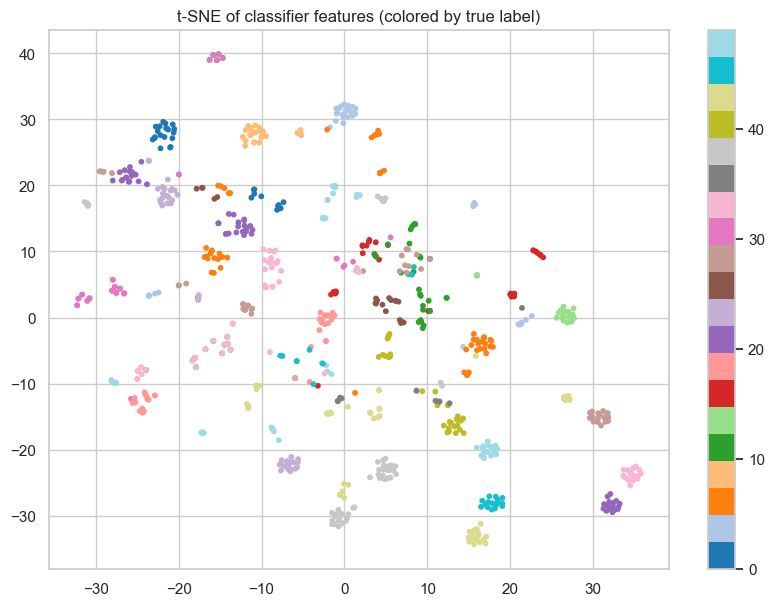

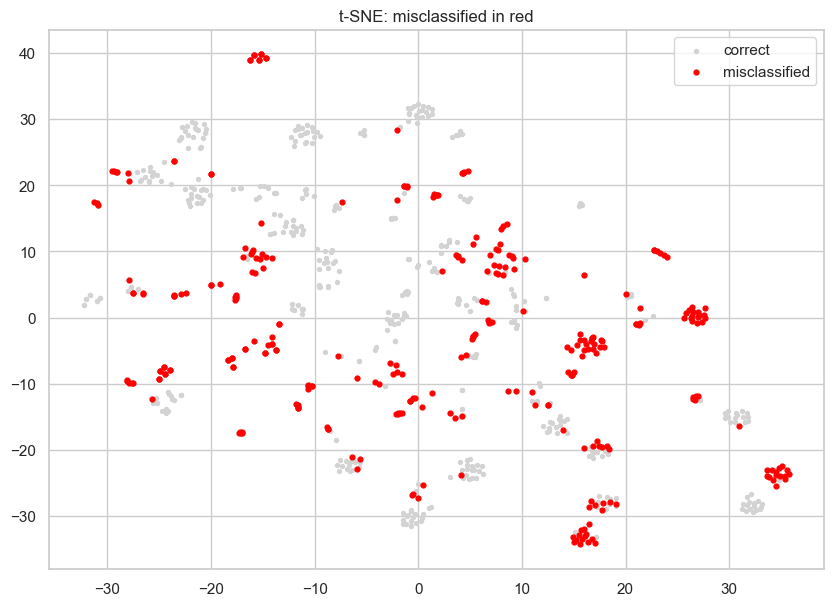

Done.


In [20]:
# Fixed Cell 9 — t-SNE / UMAP visualization (handles multi-dim features)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Parameters you can tune
FEATURES_PATH = "test_features.npy"
LOGITS_IN_MEMORY = 'all_logits' in globals()  # True if all_logits exists in workspace
PERPLEXITY = 30
PCA_DIM = 50   # set None to skip PCA; for very high-dim features, PCA before TSNE is recommended
TSNE_RANDOM_STATE = 42
TSNE_ITERS = 1000

def prepare_features(feats):
    print("Original features shape:", feats.shape)
    # If features are 4D: (N, C, H, W) -> do global average pooling over H,W -> (N, C)
    if feats.ndim == 4:
        # common case when saving convolutional feature maps
        N, C, H, W = feats.shape
        print(f"Detected 4D conv features: N={N}, C={C}, H={H}, W={W}. Applying global avg pool over (H,W).")
        feats2 = feats.mean(axis=(2,3))  # -> (N, C)
        print("After global avg pool shape:", feats2.shape)
        return feats2
    # If features are 3D: could be (N, L, D) or (N, D, 1). Try reasonable conversions:
    if feats.ndim == 3:
        N, a, b = feats.shape
        # If a small (channels) and b>1 frames, average along frames:
        if a <= 2048 and b > 1:
            # heuristics: if a is channels dim, do mean over frames (axis=2) -> (N, a)
            print(f"Detected 3D features (N, A, B) = {feats.shape}. Trying mean over axis=2 -> (N, A).")
            feats2 = feats.mean(axis=2)
            print("After mean shape:", feats2.shape)
            return feats2
        # Otherwise flatten per-sample
        print("Flattening 3D features to 2D by reshaping (N, -1).")
        feats2 = feats.reshape(N, -1)
        print("After flatten shape:", feats2.shape)
        return feats2
    # If already 2D, nothing to do
    if feats.ndim == 2:
        print("Features already 2D, shape:", feats.shape)
        return feats
    # Unexpected dims: flatten to 2D
    print("Unexpected feature dims. Flattening to (N, -1).")
    N = feats.shape[0]
    feats2 = feats.reshape(N, -1)
    print("After flatten shape:", feats2.shape)
    return feats2

try:
    feats = np.load(FEATURES_PATH)
except Exception as e:
    raise RuntimeError(f"Could not load {FEATURES_PATH}: {e}")

feats2 = prepare_features(feats)
N = feats2.shape[0]

# Align labels/preds for plotting
# 'ids' should be the list of file ids (in inference order). Try to recover if not present.
if 'ids' not in globals():
    # try to load recomputed predictions file or infer from merged
    ids = None
    try:
        if os.path.exists("recomputed_test_predictions_from_model.csv"):
            df_temp = pd.read_csv("recomputed_test_predictions_from_model.csv")
            ids = df_temp['id'].tolist()
            print(f"Loaded {len(ids)} ids from recomputed_test_predictions_from_model.csv")
    except Exception:
        ids = None

    if ids is None:
        # try to use merged (it has id and actual) but order might mismatch
        if 'merged' in globals() and 'id' in merged.columns:
            ids = merged['id'].tolist()
            print(f"Using ids from merged DataFrame (length {len(ids)}).")
        else:
            raise RuntimeError("Could not find 'ids' variable or recomputed predictions file. Provide ids that match the order of features.")

# Now build true labels and predicted labels aligned with ids
if 'merged' in globals():
    merged_idx = merged.set_index('id')
    try:
        labels_for_plot = merged_idx.loc[ids]['actual'].values
        print("Aligned true labels from merged DataFrame.")
    except Exception as e:
        raise RuntimeError(f"Failed to align merged labels with ids. Error: {e}")
else:
    raise RuntimeError("Merged DataFrame not found in workspace. Make sure you ran the CSV merge cell earlier.")

# Preds: prefer using all_logits (recomputed from model). If not present, use merged['prediction'].
if LOGITS_IN_MEMORY:
    preds_for_plot = np.argmax(all_logits, axis=1)
    print("Using predictions from in-memory all_logits.")
else:
    # fallback to merged predictions; ensure ordering by ids
    preds_for_plot = merged_idx.loc[ids]['prediction'].fillna(-1).astype(int).values
    print("Using predictions from merged DataFrame (may contain -1 for missing predictions).")

# Sanity checks
if len(labels_for_plot) != N:
    print("WARNING: number of feature rows (N) != number of labels. Trying to reconcile by using min(N, len(ids))")
    m = min(N, len(labels_for_plot))
    feats2 = feats2[:m]
    labels_for_plot = labels_for_plot[:m]
    preds_for_plot = preds_for_plot[:m]
    N = m

print(f"Final shapes -> feats: {feats2.shape}, labels: {labels_for_plot.shape}, preds: {preds_for_plot.shape}")

# Optional PCA for speed & stability
X = feats2
if PCA_DIM is not None and PCA_DIM > 0 and X.shape[1] > PCA_DIM:
    print(f"Running PCA from {X.shape[1]} -> {PCA_DIM} dims before t-SNE")
    pca = PCA(n_components=min(PCA_DIM, X.shape[1]), random_state=TSNE_RANDOM_STATE)
    X = pca.fit_transform(X)
    print("PCA done. New shape:", X.shape)

# Clamp perplexity: should be < (N-1)/3 typically
max_perp = max(5, min(PERPLEXITY, (N-1)//3))
if max_perp != PERPLEXITY:
    print(f"Adjusted perplexity from {PERPLEXITY} to {max_perp} due to small sample size ({N})")
PERPLEXITY = max_perp

print("Running t-SNE (this may take a while)...")
tsne = TSNE(n_components=2, random_state=TSNE_RANDOM_STATE, perplexity=PERPLEXITY, n_iter=TSNE_ITERS)
z = tsne.fit_transform(X)

# Plot colored by true label
plt.figure(figsize=(10,7))
scatter = plt.scatter(z[:,0], z[:,1], c=labels_for_plot, cmap='tab20', s=10)
plt.title("t-SNE of classifier features (colored by true label)")
plt.colorbar()
plt.show()

# Highlight misclassified points
mis = (labels_for_plot != preds_for_plot)
plt.figure(figsize=(10,7))
plt.scatter(z[~mis,0], z[~mis,1], c='lightgray', s=8, label='correct')
plt.scatter(z[mis,0], z[mis,1], c='red', s=12, label='misclassified')
plt.legend()
plt.title("t-SNE: misclassified in red")
plt.show()

print("Done.")


In [22]:
# Fixed Cell 10 — Robust MFCC / mel-centroid distances to class centroids
import librosa
from collections import defaultdict
from scipy.spatial.distance import euclidean
import numpy as np
import os
import pandas as pd

def safe_melspectrogram(y, sr, n_mels=128, n_fft=2048, hop_length=512):
    """
    Compute mel-spectrogram robustly:
      - try librosa.feature.melspectrogram(y=..., sr=..., n_mels=...)
      - fallback to manual STFT -> mel filterbank -> power_to_db
    Returns: S_db (n_mels, n_frames)
    """
    try:
        # preferred API (explicit keywords)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.power_to_db(S, ref=np.max)
        return S_db
    except TypeError as e:
        print("librosa.feature.melspectrogram raised TypeError — falling back to manual computation. Error:", e)
    except Exception as e:
        # catch-all fallback with message but continue
        print("librosa.feature.melspectrogram failed; fallback. Error:", e)

    # Fallback manual computation
    # 1) compute STFT-power spectrogram
    S_complex = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, center=True)
    S_power = np.abs(S_complex) ** 2  # power spectrogram
    # 2) build mel filterbank
    mel_fb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    # 3) apply mel filterbank (mel_fb: n_mels x (n_fft/2+1))
    S_mel = np.dot(mel_fb, S_power)
    S_db = librosa.power_to_db(S_mel, ref=np.max)
    return S_db

def compute_mel_centroids(train_audio_dir, train_meta_csv, sr=44100, n_mels=128, n_fft=2048, hop_length=512):
    """
    For each class in train_meta_csv, compute average (mean over time) mel-spectrogram vector -> centroid.
    Returns dict: centroids[class] = 1D numpy array length n_mels
    """
    meta = pd.read_csv(train_meta_csv)
    centroids = {}
    class_counts = defaultdict(int)
    sums = defaultdict(lambda: None)

    # Debugging info
    total = len(meta)
    print(f"Processing {total} training files from metadata to compute centroids...")
    for idx, row in meta.iterrows():
        fname = row.get('filename') or row.get('file') or row.get('audio')  # defensive
        target = int(row.get('target') if 'target' in row else row.get('label') if 'label' in row else row.iloc[-1])
        fp = os.path.join(train_audio_dir, fname)
        if not os.path.exists(fp):
            # try alternative extensions / path variants
            # skip if not found
            # print(f"Missing train audio file: {fp} (skipping)")
            continue
        try:
            y, _sr = librosa.load(fp, sr=sr)
        except Exception as e:
            print(f"Failed to load {fp}: {e}. Skipping.")
            continue

        S_db = safe_melspectrogram(y, sr=_sr if _sr is not None else sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        # average across time axis -> n_mels-dim vector
        vec = np.mean(S_db, axis=1)

        if sums[target] is None:
            sums[target] = vec
        else:
            sums[target] = sums[target] + vec
        class_counts[target] += 1

    for c in sums:
        centroids[c] = sums[c] / max(1, class_counts[c])
    print(f"Computed centroids for {len(centroids)} classes (non-empty).")
    return centroids

# Run centroid computation if paths present
if os.path.exists(TRAIN_META_CSV) and os.path.exists(TRAIN_AUDIO_DIR):
    print("Computing class mel-centroids (this may take a while)...")
    centroids = compute_mel_centroids(TRAIN_AUDIO_DIR, TRAIN_META_CSV, sr=CFG.SAMPLING_RATE, n_mels=128)
    # For misclassified examples, compute distance to true centroid vs predicted centroid
    mis_df = merged[(merged['prediction'].notna()) & (merged['prediction'] != merged['actual'])]
    if len(mis_df) == 0:
        print("No misclassified samples found in merged DataFrame (or predictions missing).")
    else:
        sample = mis_df.sample(min(30, len(mis_df)), random_state=42)  # random sample to inspect
        rows = []
        for idx, r in sample.iterrows():
            fid = r['id']
            actual = int(r['actual']); pred = int(r['prediction'])
            # try multiple file extensions if wav missing
            wav_path = os.path.join(TEST_AUDIO_DIR, fid + ".wav")
            if not os.path.exists(wav_path):
                alt = None
                for ext in ['.wav', '.flac', '.mp3', '.WAV', '.FLAC', '.MP3']:
                    candidate = os.path.join(TEST_AUDIO_DIR, fid + ext)
                    if os.path.exists(candidate):
                        alt = candidate
                        break
                if alt is None:
                    # try glob
                    try:
                        from glob import glob
                        matches = glob(os.path.join(TEST_AUDIO_DIR, fid + ".*"))
                        if matches:
                            wav_path = matches[0]
                        else:
                            print(f"Missing test audio for id {fid}, skipping.")
                            continue
                    except Exception:
                        print(f"Missing test audio for id {fid}, skipping.")
                        continue
                else:
                    wav_path = alt
            try:
                y, sr = librosa.load(wav_path, sr=CFG.SAMPLING_RATE)
            except Exception as e:
                print(f"Failed to load {wav_path}: {e}. Skipping.")
                continue

            S_db = safe_melspectrogram(y, sr=sr, n_mels=128)
            vec = np.mean(S_db, axis=1)
            # if centroid for a class missing, fallback to zeros vector (same length)
            c_true = centroids.get(actual, np.zeros_like(vec))
            c_pred = centroids.get(pred, np.zeros_like(vec))
            d_true = euclidean(vec, c_true)
            d_pred = euclidean(vec, c_pred)
            rows.append((fid, actual, pred, d_true, d_pred))
        if rows:
            df_dist = pd.DataFrame(rows, columns=["id","actual","pred","dist_to_true","dist_to_pred"])
            display(df_dist.sort_values("dist_to_pred").reset_index(drop=True))
        else:
            print("No rows collected for centroid-distance analysis (maybe missing audio files).")
else:
    print("TRAIN_META_CSV or TRAIN_AUDIO_DIR missing or not found; skip centroid analysis.")


Computing class mel-centroids (this may take a while)...
Processing 2000 training files from metadata to compute centroids...
Computed centroids for 50 classes (non-empty).


,id,actual,pred,dist_to_true,dist_to_pred
0,7-280602-A-506,47,45,97.280952,50.337276
1,7-280602-A-082,12,38,53.479706,81.650459
2,7-280602-A-113,7,13,128.992065,90.414612
3,7-280602-A-521,41,36,70.305534,94.909111
4,7-280602-A-372,46,47,114.911636,100.975044
5,7-280602-A-375,46,47,111.156021,105.596619
6,7-280602-A-627,25,10,258.639404,106.954964
7,7-280602-A-089,45,12,188.538574,112.441353
8,7-280602-A-224,19,48,177.048279,113.157822
9,7-280602-A-319,5,20,67.577011,129.297058
